In [1]:
from google.colab import files 
uploaded = files.upload()

Saving ^AXJO.csv to ^AXJO (1).csv


In [2]:
from google.colab import files 
uploaded = files.upload()

Saving australia_news.csv to australia_news (1).csv


In [4]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import xgboost 
import lightgbm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [5]:
!pip install pmdarima

**TIME-SERIES ANALYSIS OF AXJO STOCKS**

In [6]:
df_prices = pd.read_csv('^AXJO.csv')
print(df_prices.head())
print(df_prices.size)

         Date         Open         High  ...        Close    Adj Close  Volume
0  2015-01-02  5411.000000  5436.299805  ...  5435.899902  5435.899902     0.0
1  2015-01-05  5435.899902  5470.399902  ...  5450.299805  5450.299805     0.0
2  2015-01-06  5450.299805  5450.299805  ...  5364.799805  5364.799805     0.0
3  2015-01-07  5364.799805  5369.799805  ...  5353.600098  5353.600098     0.0
4  2015-01-08  5353.600098  5395.799805  ...  5381.500000  5381.500000     0.0

[5 rows x 7 columns]
8862


In [7]:
#Converting Date column to datetime datatype
df_prices['Date'] = pd.to_datetime(df_prices['Date'])
df_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1266 entries, 0 to 1265
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1266 non-null   datetime64[ns]
 1   Open       1264 non-null   float64       
 2   High       1264 non-null   float64       
 3   Low        1264 non-null   float64       
 4   Close      1264 non-null   float64       
 5   Adj Close  1264 non-null   float64       
 6   Volume     1264 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 69.4 KB


In [8]:
df_prices.dropna(inplace = True)

Text(0, 0.5, 'Close')

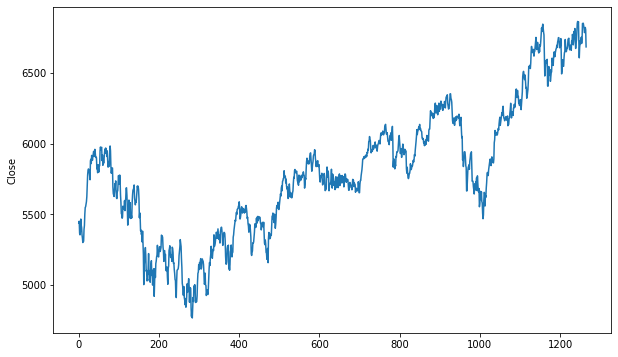

In [9]:
plt.figure(figsize=(10, 6))
df_prices['Close'].plot()
plt.ylabel('Close')

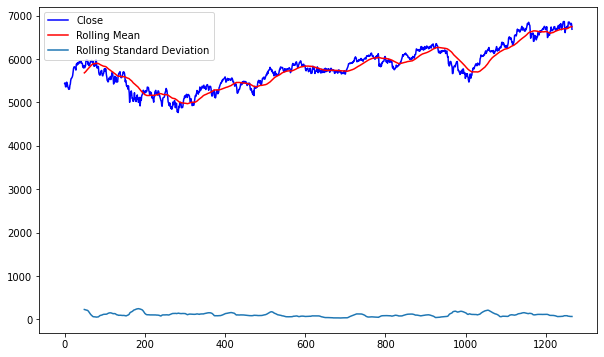

In [10]:
#Plotting moving average
close = df_prices['Close']
ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

plt.figure(figsize=(10, 6))
df_prices['Close'].plot(color = 'b', label = 'Close')
ma.plot(color = 'r', label = 'Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')
plt.legend()

Text(0.5, 1.0, 'Returns')

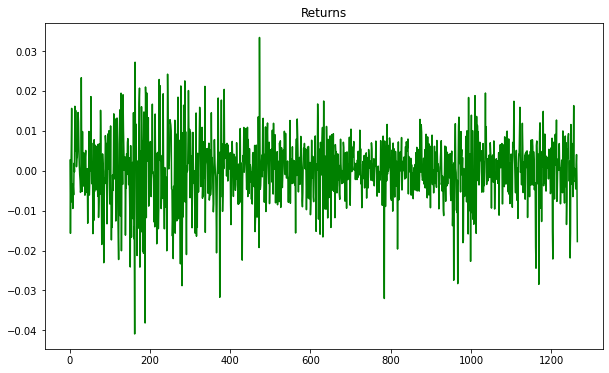

In [11]:
#Plotting returns
returns = close / close.shift(1) - 1

plt.figure(figsize = (10,6))
returns.plot(label='Return', color = 'g')
plt.title("Returns")

In [12]:
train = df_prices[:1000]
test = df_prices[1000:]

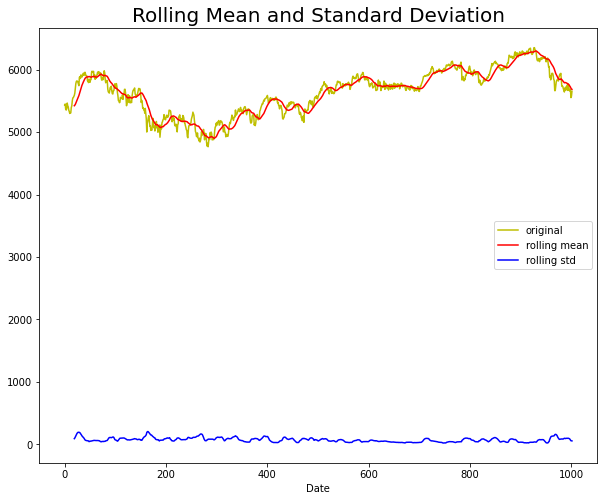

Results of dickey fuller test
ADF Test Statistic : -2.06210460581863
p-value : 0.26002289258636335
#Lags Used : 0
Number of Observations Used : 999
Weak evidence against null hypothesis, time series is non-stationary 


In [13]:
#Stationarity test
def test_stationarity(timeseries):

 #Determing rolling statistics
 rolmean = timeseries.rolling(20).mean()
 rolstd = timeseries.rolling(20).std()

 #Plot rolling statistics:
 plt.figure(figsize = (10,8))
 plt.plot(timeseries, color = 'y', label = 'original')
 plt.plot(rolmean, color = 'r', label = 'rolling mean')
 plt.plot(rolstd, color = 'b', label = 'rolling std')
 plt.xlabel('Date')
 plt.legend()
 plt.title('Rolling Mean and Standard Deviation',  fontsize = 20)
 plt.show(block = False)
 
 print('Results of dickey fuller test')
 result = adfuller(timeseries, autolag = 'AIC')
 labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
 for value,label in zip(result, labels):
   print(label+' : '+str(value) )
 if result[1] <= 0.05:
   print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
 else:
   print("Weak evidence against null hypothesis, time series is non-stationary ")
test_stationarity(train['Close'])


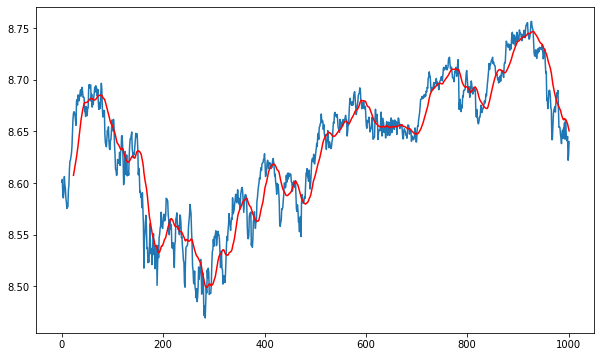

In [14]:
train_log = np.log(train['Close']) 
test_log = np.log(test['Close'])

mav = train_log.rolling(24).mean() 
plt.figure(figsize = (10,6))
plt.plot(train_log) 
plt.plot(mav, color = 'red')

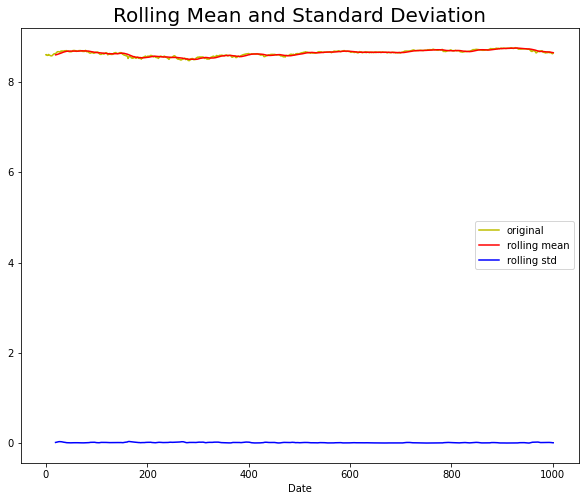

Results of dickey fuller test
ADF Test Statistic : -2.10091549160808
p-value : 0.24414663710966727
#Lags Used : 0
Number of Observations Used : 999
Weak evidence against null hypothesis, time series is non-stationary 


In [15]:
train_log.dropna(inplace = True)
test_log.dropna(inplace = True)

test_stationarity(train_log)

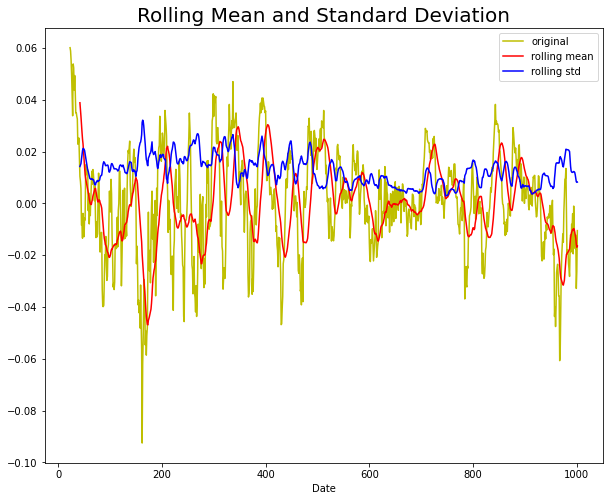

Results of dickey fuller test
ADF Test Statistic : -6.9974894116259385
p-value : 7.468388129023152e-10
#Lags Used : 0
Number of Observations Used : 976
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [16]:
train_log_diff = train_log - mav
train_log_diff.dropna(inplace = True)

test_stationarity(train_log_diff)

In [17]:
#Using auto arima to make predictions using log data
from pmdarima import auto_arima
model = auto_arima(train_log, trace = True, error_action = 'ignore', suppress_warnings = True)
model.fit(train_log)
predictions = model.predict(n_periods = len(test))
predictions = pd.DataFrame(predictions,index = test_log.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-6710.743, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6718.743, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6716.745, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6716.744, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6720.720, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6714.742, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.662 seconds


Text(0, 0.5, 'Actual Stock Price')

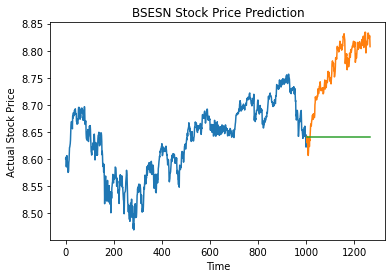

In [18]:
plt.plot(train_log, label='Train')
plt.plot(test_log, label='Test')
plt.plot(predictions, label='Prediction')
plt.title('BSESN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')

In [19]:
#Calculating error
rms = np.sqrt(mean_squared_error(test_log,predictions))
print("RMSE : ", rms)

RMSE :  0.13609085335232343


**TEXTUAL ANALYSIS OF AUSTRALIA NEWS HEADLINES**

In [20]:
cols = ['Date','News']
df_news = pd.read_csv('australia_news.csv', names = cols)
df_news

,Date,News
0,publish_date,headline_text
1,20150102,abalone salmon fish farming environment
2,20150102,abalone salmon tassal huon aquaculture aquacul...
3,20150102,act government approves changes to asbestos ma...
4,20150102,activist to send copies of the interview to no...
...,...,...
260403,20191231,vision of flames approaching corryong in victoria
260404,20191231,wa police and government backflip on drug amne...
260405,20191231,we have fears for their safety: victorian premier
260406,20191231,when do the 20s start


In [21]:
df_news.drop(0, inplace=True)
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260407 entries, 1 to 260407
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Date    260407 non-null  object
 1   News    260407 non-null  object
dtypes: object(2)
memory usage: 6.0+ MB


In [22]:
#Converting data type of Date column 
df_news['Date'] = pd.to_datetime(df_news['Date'],format= '%Y%m%d')
df_news

,Date,News
1,2015-01-02,abalone salmon fish farming environment
2,2015-01-02,abalone salmon tassal huon aquaculture aquacul...
3,2015-01-02,act government approves changes to asbestos ma...
4,2015-01-02,activist to send copies of the interview to no...
5,2015-01-02,agricultural graduate job access limited by la...
...,...,...
260403,2019-12-31,vision of flames approaching corryong in victoria
260404,2019-12-31,wa police and government backflip on drug amne...
260405,2019-12-31,we have fears for their safety: victorian premier
260406,2019-12-31,when do the 20s start


In [23]:
#Grouping the headlines for each day
df_news['News'] = df_news.groupby(['Date']).transform(lambda x : ' '.join(x)) 
df_news = df_news.drop_duplicates() 
df_news.reset_index(inplace = True, drop = True)
df_news

,Date,News
0,2015-01-02,abalone salmon fish farming environment abalon...
1,2015-01-03,adelaide hills face most dangerous fire day si...
2,2015-01-04,12 year old boy dies from deodorant sniffing i...
3,2015-01-05,26 houses destroyed in sa fires adelaide hills...
4,2015-01-06,airasia black box may be buried australian tra...
...,...,...
1820,2019-12-27,abc pic of the week best of 2019 alexei navaln...
1821,2019-12-28,acosia red elk demonstrating jingle dress danc...
1822,2019-12-29,alcohol addiction made me a drug dealer and se...
1823,2019-12-30,aerial firefighting over bundoora african swin...


In [24]:
df_news['News']

0       abalone salmon fish farming environment abalon...
1       adelaide hills face most dangerous fire day si...
2       12 year old boy dies from deodorant sniffing i...
3       26 houses destroyed in sa fires adelaide hills...
4       airasia black box may be buried australian tra...
                              ...                        
1820    abc pic of the week best of 2019 alexei navaln...
1821    acosia red elk demonstrating jingle dress danc...
1822    alcohol addiction made me a drug dealer and se...
1823    aerial firefighting over bundoora african swin...
1824    abc reporter liv casben had to seek shelter at...
Name: News, Length: 1825, dtype: object

In [25]:
#Cleaning the tweets

def decontracted(phrase):
   # specific
   phrase = re.sub(r"won't", "will not", phrase)
   phrase = re.sub(r"can\'t", "can not", phrase)
   
   # general
   phrase = re.sub(r"n\'t", " not", phrase)
   phrase = re.sub(r"\'re", " are", phrase)
   phrase = re.sub(r"\'s", " is", phrase)
   phrase = re.sub(r"\'d", " would", phrase)
   phrase = re.sub(r"\'ll", " will", phrase)
   phrase = re.sub(r"\'t", " not", phrase)
   phrase = re.sub(r"\'ve", " have", phrase)
   phrase = re.sub(r"\'m", " am", phrase)
   return phrase
 
def clean(text):
   text = str(text)
   text = text.lower()
   text = re.sub(r'http\S+', ' ', text)
   text = decontracted(text)
   text = re.sub(r'\(([^)]+)\)', " ", text)
   text = text.replace('etmarkets', ' ').replace('marketupdates', ' ').replace('newsalert', ' ').replace('ndtv', ' ').replace('moneycontrol', ' ').replace('here is why', ' ')
   text = text.replace('marketsupdate', ' ').replace('biznews', ' ').replace('click here', ' ').replace('live updates', ' ').replace('et now', ' ')
   text = re.sub(r'[^a-zA-Z ]+', ' ', text)
   text = re.sub(r' \w{1,2}_', ' ', text)
   text = re.sub('\s+',' ', text)
   return text

In [26]:
df_news.News = df_news.News.apply(lambda x: clean(x))

In [27]:
df_news['News']

0       abalone salmon fish farming environment abalon...
1       adelaide hills face most dangerous fire day si...
2        year old boy dies from deodorant sniffing in ...
3        houses destroyed in sa fires adelaide hills f...
4       airasia black box may be buried australian tra...
                              ...                        
1820    abc pic of the week best of alexei navalny off...
1821    acosia red elk demonstrating jingle dress danc...
1822    alcohol addiction made me a drug dealer and se...
1823    aerial firefighting over bundoora african swin...
1824    abc reporter liv casben had to seek shelter at...
Name: News, Length: 1825, dtype: object

In [28]:
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return  TextBlob(text).sentiment.polarity

In [29]:
#Adding subjectivity and polarity columns
df_news['Subjectivity'] = df_news['News'].apply(getSubjectivity)
df_news['Polarity'] = df_news['News'].apply(getPolarity)
df_news

,Date,News,Subjectivity,Polarity
0,2015-01-02,abalone salmon fish farming environment abalon...,0.396251,0.072491
1,2015-01-03,adelaide hills face most dangerous fire day si...,0.425466,0.042467
2,2015-01-04,year old boy dies from deodorant sniffing in ...,0.268105,0.017887
3,2015-01-05,houses destroyed in sa fires adelaide hills f...,0.336124,0.049471
4,2015-01-06,airasia black box may be buried australian tra...,0.365741,0.096296
...,...,...,...,...
1820,2019-12-27,abc pic of the week best of alexei navalny off...,0.403056,0.147156
1821,2019-12-28,acosia red elk demonstrating jingle dress danc...,0.334993,0.066252
1822,2019-12-29,alcohol addiction made me a drug dealer and se...,0.388762,0.105008
1823,2019-12-30,aerial firefighting over bundoora african swin...,0.327228,0.085472


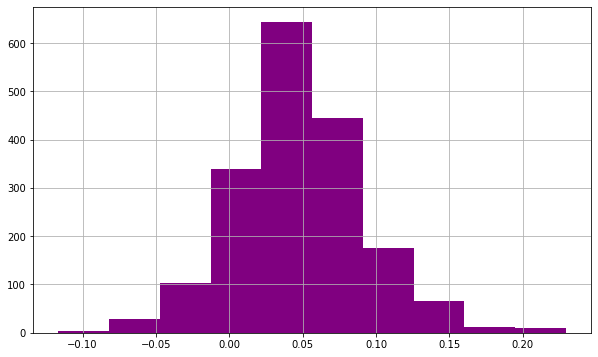

In [30]:
plt.figure(figsize = (10,6))
df_news['Polarity'].hist(color = 'purple')

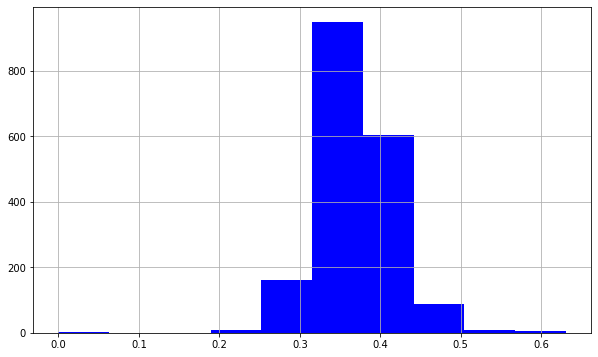

In [31]:
plt.figure(figsize = (10,6))
df_news['Subjectivity'].hist(color = 'blue')

In [32]:
# added new words in VADER to judge stock market better

new_words = {'falls': -9, 'drops': -9, 'rise': 9, 'increases': 9, 'gain': 9, 'hiked': -9, 'dips': -9, 'declines': -9,
'decline': -9, 'hikes': -9, 'jumps': 9, 'lose': -9, 'profit': 9, 'loss': -9, 'shreds': -9, 'sell': -9, 'buy': 9, 'recession': -9,
'australian dollar weakens': -9, 'record low': -9, 'record high': 9, 'asx up': 9, 'asx down': -9}

analyser = SentimentIntensityAnalyzer()
analyser.lexicon.update(new_words)

In [33]:
# adding sentiment score to News

df_news['Compound'] = [analyser.polarity_scores(v)['compound'] for v in df_news['News']]
df_news['Negative'] = [analyser.polarity_scores(v)['neg'] for v in df_news['News']]
df_news['Neutral'] = [analyser.polarity_scores(v)['neu'] for v in df_news['News']]
df_news['Positive'] = [analyser.polarity_scores(v)['pos'] for v in df_news['News']]
df_news

,Date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2015-01-02,abalone salmon fish farming environment abalon...,0.396251,0.072491,-0.9670,0.158,0.703,0.139
1,2015-01-03,adelaide hills face most dangerous fire day si...,0.425466,0.042467,-0.9969,0.203,0.705,0.092
2,2015-01-04,year old boy dies from deodorant sniffing in ...,0.268105,0.017887,-0.9987,0.205,0.744,0.050
3,2015-01-05,houses destroyed in sa fires adelaide hills f...,0.336124,0.049471,-0.9945,0.173,0.731,0.096
4,2015-01-06,airasia black box may be buried australian tra...,0.365741,0.096296,0.5789,0.127,0.764,0.110
...,...,...,...,...,...,...,...,...
1820,2019-12-27,abc pic of the week best of alexei navalny off...,0.403056,0.147156,0.9710,0.117,0.734,0.149
1821,2019-12-28,acosia red elk demonstrating jingle dress danc...,0.334993,0.066252,-0.7717,0.142,0.728,0.130
1822,2019-12-29,alcohol addiction made me a drug dealer and se...,0.388762,0.105008,-0.9954,0.243,0.632,0.125
1823,2019-12-30,aerial firefighting over bundoora african swin...,0.327228,0.085472,-0.9888,0.164,0.782,0.054


In [34]:
df_merge = pd.merge(df_prices, df_news, how='inner', on='Date')
df_merge

,Date,Open,High,Low,Close,Adj Close,Volume,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2015-01-02,5411.000000,5436.299805,5387.000000,5435.899902,5435.899902,0.0,abalone salmon fish farming environment abalon...,0.396251,0.072491,-0.9670,0.158,0.703,0.139
1,2015-01-05,5435.899902,5470.399902,5429.600098,5450.299805,5450.299805,0.0,houses destroyed in sa fires adelaide hills f...,0.336124,0.049471,-0.9945,0.173,0.731,0.096
2,2015-01-06,5450.299805,5450.299805,5338.600098,5364.799805,5364.799805,0.0,airasia black box may be buried australian tra...,0.365741,0.096296,0.5789,0.127,0.764,0.110
3,2015-01-07,5364.799805,5369.799805,5318.700195,5353.600098,5353.600098,0.0,bali nine member mayuran sukumaran loses appea...,0.430429,-0.080022,-0.9948,0.288,0.660,0.052
4,2015-01-08,5353.600098,5395.799805,5353.600098,5381.500000,5381.500000,0.0,bindoon volunteer firefighters survive burnove...,0.302564,-0.003846,0.6705,0.042,0.881,0.077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1259,2019-12-23,6816.299805,6816.299805,6785.100098,6785.100098,6785.100098,364700.0,accused religious fraudster ripped m from wors...,0.321050,-0.054816,-0.9974,0.225,0.644,0.132
1260,2019-12-24,6785.100098,6794.899902,6776.200195,6794.200195,6794.200195,201800.0,killed as bus plunges into ravine in indonesi...,0.296311,0.025105,-0.9955,0.175,0.757,0.068
1261,2019-12-27,6794.200195,6822.100098,6794.200195,6821.700195,6821.700195,290100.0,abc pic of the week best of alexei navalny off...,0.403056,0.147156,0.9710,0.117,0.734,0.149
1262,2019-12-30,6821.700195,6824.700195,6764.600098,6804.899902,6804.899902,294800.0,aerial firefighting over bundoora african swin...,0.327228,0.085472,-0.9888,0.164,0.782,0.054


In [35]:
df = df_merge[['Close','Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral' ,'Positive']]
df

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,5435.899902,0.396251,0.072491,-0.9670,0.158,0.703,0.139
1,5450.299805,0.336124,0.049471,-0.9945,0.173,0.731,0.096
2,5364.799805,0.365741,0.096296,0.5789,0.127,0.764,0.110
3,5353.600098,0.430429,-0.080022,-0.9948,0.288,0.660,0.052
4,5381.500000,0.302564,-0.003846,0.6705,0.042,0.881,0.077
...,...,...,...,...,...,...,...
1259,6785.100098,0.321050,-0.054816,-0.9974,0.225,0.644,0.132
1260,6794.200195,0.296311,0.025105,-0.9955,0.175,0.757,0.068
1261,6821.700195,0.403056,0.147156,0.9710,0.117,0.734,0.149
1262,6804.899902,0.327228,0.085472,-0.9888,0.164,0.782,0.054


In [36]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
new_df = pd.DataFrame(sc.fit_transform(df))
new_df.columns = df.columns
new_df.index = df.index
new_df.head()

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.319531,0.718150,0.650088,0.016486,0.548611,0.214286,0.798851
1,0.326392,0.609178,0.570883,0.002706,0.600694,0.288360,0.551724
2,0.285653,0.662854,0.731991,0.791141,0.440972,0.375661,0.632184
3,0.280316,0.780092,0.125352,0.002556,1.000000,0.100529,0.298851
4,0.293610,0.548355,0.387441,0.837041,0.145833,0.685185,0.442529


In [37]:
X = new_df.drop('Close', axis=1)
y = new_df['Close']

In [38]:
X.head()

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.718150,0.650088,0.016486,0.548611,0.214286,0.798851
1,0.609178,0.570883,0.002706,0.600694,0.288360,0.551724
2,0.662854,0.731991,0.791141,0.440972,0.375661,0.632184
3,0.780092,0.125352,0.002556,1.000000,0.100529,0.298851
4,0.548355,0.387441,0.837041,0.145833,0.685185,0.442529


In [39]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)
x_train.shape

(1011, 6)

In [40]:
x_train[:10]

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
31,0.608455,0.498568,0.000050,0.770833,0.068783,0.747126
412,0.630574,0.412302,0.000200,0.673611,0.193122,0.637931
64,0.637332,0.551458,0.001654,0.506944,0.317460,0.643678
957,0.691133,0.498499,0.000651,0.649306,0.335979,0.367816
1208,0.833326,0.556192,0.005612,0.565972,0.251323,0.683908
505,0.678290,0.721385,0.005061,0.538194,0.312169,0.603448
1213,0.633695,0.421303,0.000551,0.656250,0.328042,0.367816
920,0.609400,0.469924,0.000902,0.621528,0.291005,0.511494
740,0.689754,0.595403,0.000601,0.611111,0.275132,0.563218
999,0.659840,0.370484,0.001353,0.569444,0.325397,0.522989


In [41]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
prediction=rf.predict(x_test)

In [42]:
print(prediction[:10])
print(y_test[:10])
print(mean_squared_error(prediction,y_test))

[0.54131273 0.47631523 0.5645538  0.40952738 0.78651357 0.36198322
 0.38006508 0.44453144 0.28404116 0.58636682]
1163    0.866775
299     0.163292
747     0.598704
5       0.333683
1165    0.859199
427     0.295659
731     0.570925
658     0.476676
320     0.082099
689     0.436842
Name: Close, dtype: float64
0.02415099330000142


In [43]:
adb = AdaBoostRegressor()
adb.fit(x_train, y_train)
predictions = adb.predict(x_test)

In [44]:
print(mean_squared_error(predictions, y_test))

0.030872531374447704


In [45]:
from sklearn.tree import DecisionTreeRegressor
dec_tree = DecisionTreeRegressor()
dec_tree.fit(x_train, y_train)
predictions = dec_tree.predict(x_test)

In [46]:
print(predictions[:10])
print(y_test[:10])
print(mean_squared_error(predictions,y_test))

[0.19907574 0.47972564 0.61561914 0.39038463 0.93858108 0.42221376
 0.46843284 0.67884884 0.19307198 0.63210558]
1163    0.866775
299     0.163292
747     0.598704
5       0.333683
1165    0.859199
427     0.295659
731     0.570925
658     0.476676
320     0.082099
689     0.436842
Name: Close, dtype: float64
0.05068240280497583


In [47]:
lgb = lightgbm.LGBMRegressor()
lgb.fit(x_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [48]:
predictions = lgb.predict(x_test)
print(mean_squared_error(predictions,y_test))

0.02474222428039369


In [49]:
xgb = xgboost.XGBRegressor()
xgb.fit(x_train, y_train)

[03:51:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [50]:
predictions = xgb.predict(x_test)
print(mean_squared_error(predictions,y_test))

0.02506060384504161


RandomForest = 0.024892547852246108

AdaBoost = 0.029284634457126864

DecisionTree = 0.04973942603387117

LightGBM = 0.02474222428039369

XGBoost = 0.02506060384504161

Out of all the the machine learning algorithms, **LightGBM is the best to use for sentiment analysis**